In [1]:
#import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression 
import numpy as np
from sklearn.inspection import permutation_importance

# Data Preprocessing and Feature engineering

In [2]:
#reading in the data and understanding it
df = pd.read_csv('fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [3]:
df['time'] = pd.to_timedelta(df['step'], unit='h')
df['time_string'] = df['time'].astype(str)
df['time_of_day'] = df['time_string'].str[-8:].astype(str)
df['time_of_day'] =df['time_of_day'].str[:2].astype(int)
df['time_of_day'].value_counts()

11    26598
10    26544
9     26541
8     26513
7     26494
6     26366
5     26363
4     26292
3     26205
2     26105
1     25935
0     25912
23    23570
22    23476
21    23415
20    23393
18    23313
19    23270
15    23168
17    23145
14    23071
16    23015
12    22979
13    22960
Name: time_of_day, dtype: int64

In [4]:
df.drop(['time', 'time_string', 'step'], axis = 1, inplace = True)
df.describe()

,amount,fraud,time_of_day
count,594643.000000,594643.000000,594643.000000
mean,37.890135,0.012108,11.154182
std,111.402831,0.109369,6.911148
min,0.000000,0.000000,0.000000
25%,13.740000,0.000000,5.000000
50%,26.900000,0.000000,11.000000
75%,42.540000,0.000000,17.000000
max,8329.960000,1.000000,23.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer     594643 non-null  object 
 1   age          594643 non-null  object 
 2   gender       594643 non-null  object 
 3   zipcodeOri   594643 non-null  object 
 4   merchant     594643 non-null  object 
 5   zipMerchant  594643 non-null  object 
 6   category     594643 non-null  object 
 7   amount       594643 non-null  float64
 8   fraud        594643 non-null  int64  
 9   time_of_day  594643 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(7)
memory usage: 43.1+ MB


In [6]:
df.describe()

,amount,fraud,time_of_day
count,594643.000000,594643.000000,594643.000000
mean,37.890135,0.012108,11.154182
std,111.402831,0.109369,6.911148
min,0.000000,0.000000,0.000000
25%,13.740000,0.000000,5.000000
50%,26.900000,0.000000,11.000000
75%,42.540000,0.000000,17.000000
max,8329.960000,1.000000,23.000000


In [7]:
df.nunique()

customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         23767
fraud              2
time_of_day       24
dtype: int64

In [8]:
df['zipcodeOri'].value_counts()

'28007'    594643
Name: zipcodeOri, dtype: int64

In [9]:
df['zipMerchant'].value_counts()

'28007'    594643
Name: zipMerchant, dtype: int64

## from the above sell we can see that the columns ("zipcodeOri", "zipMerchant") only have one vavlue i.e. these columns will not have any impact on this predictive case so they will be droped.

In [10]:
df.drop(['zipcodeOri', 'zipMerchant'], axis = 1, inplace = True)
df.head()

,customer,age,gender,merchant,category,amount,fraud,time_of_day
0,'C1093826151','4','M','M348934600','es_transportation',4.55,0,0
1,'C352968107','2','M','M348934600','es_transportation',39.68,0,0
2,'C2054744914','4','F','M1823072687','es_transportation',26.89,0,0
3,'C1760612790','3','M','M348934600','es_transportation',17.25,0,0
4,'C757503768','5','M','M348934600','es_transportation',35.72,0,0


In [11]:
df.nunique()

customer        4112
age                8
gender             4
merchant          50
category          15
amount         23767
fraud              2
time_of_day       24
dtype: int64

In [12]:
df.isna().sum()

customer       0
age            0
gender         0
merchant       0
category       0
amount         0
fraud          0
time_of_day    0
dtype: int64

### No missing values found

In [13]:
df.duplicated().sum()

143

### No duplicates were found

# Performing EDA:

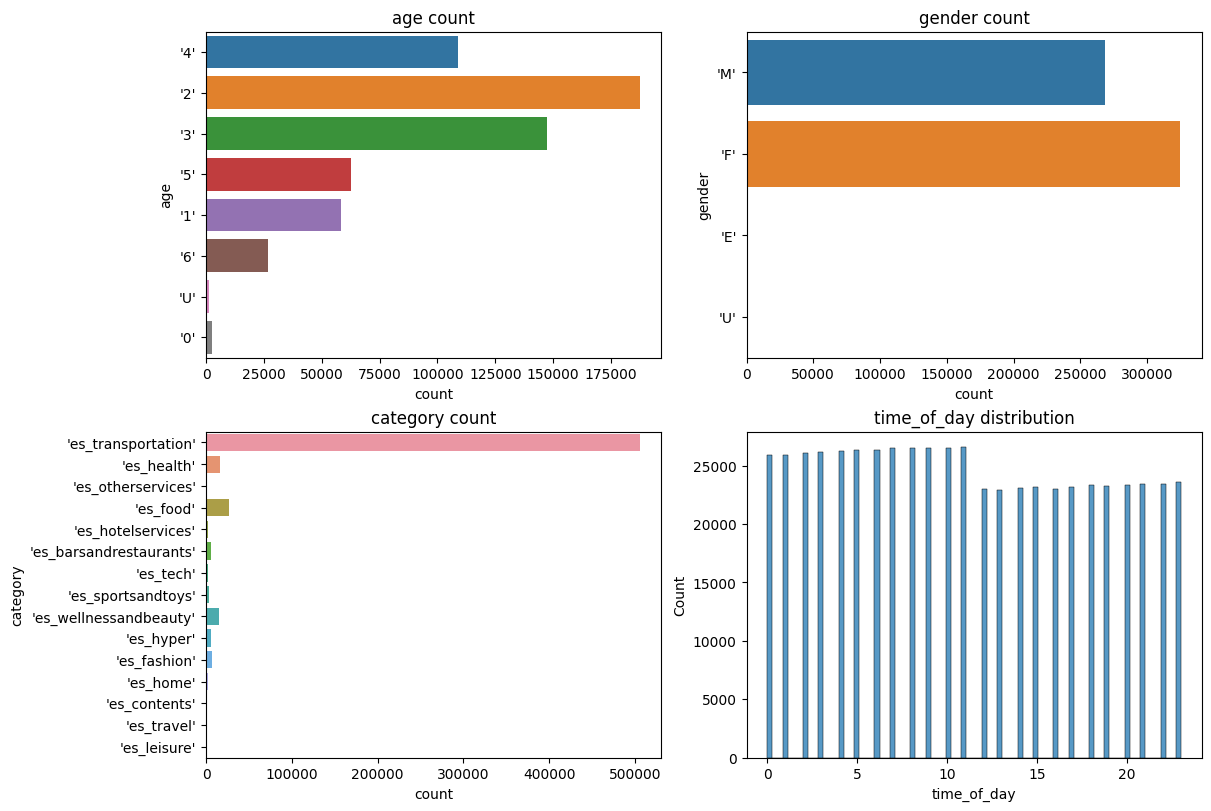

In [16]:
def plotting_features(data):
    
    '''
    Return to distribution of numerical features and count of 
    categorical features, specific features will ignore them,
    because they do not give us any meaning.
    
    '''
 
    ignored_cols = ['customer', 'merchant', 'fraud', 'amount']
    cols = [ col for col in data.columns if col not in ignored_cols]
 
    nrows= int(np.ceil(len(cols)/2))
    fig, ax = plt.subplots(
                        nrows=nrows, 
                        ncols=2, 
                        figsize=(12,8),   
                        constrained_layout=True)
    ax = ax.ravel()
 
    for i in range(len(cols)):
        if (data[cols[i]].dtypes == 'object') | (len(data[cols[i]].unique().tolist()) < 10): 
            
            sns.countplot(y = data[cols[i]], ax=ax[i])
            ax[i].set_title(f'{cols[i]} count')
 
        else:
            sns.histplot(x = data[cols[i]], ax=ax[i])
            ax[i].set_title(f'{cols[i]} distribution');
plotting_features(df)

## 1- Univariate Exploration:

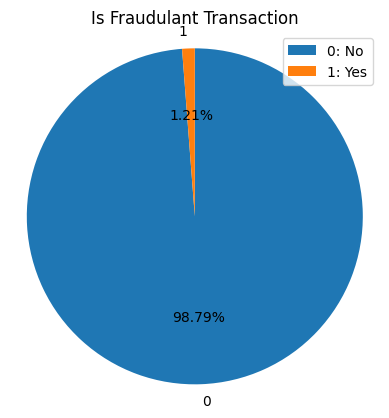

In [17]:

plt.pie(df['fraud'].value_counts(), labels = df["fraud"].value_counts().index,
        startangle = 90,counterclock = False, autopct='%1.2f%%');
plt.axis('square')
plt.gca().set_aspect("equal")
plt.title('Is Fraudulant Transaction');
plt.ylabel('');
plt.legend(["0: No", "1: Yes"]);

### the above pie chart suggests that we have a big data imbalance.

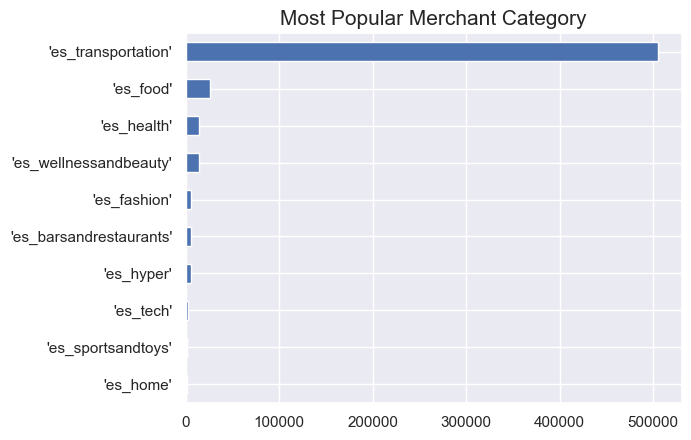

In [81]:
plt.title('Most Popular Merchant Category', fontsize=15)
df[df['fraud'] == 0].category.value_counts(ascending=True).tail(10).plot.barh();

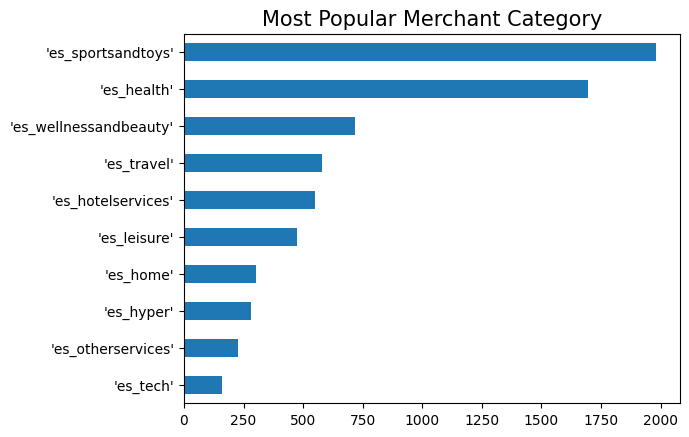

In [19]:
plt.title('Most Popular Merchant Category', fontsize=15)
df[df['fraud'] == 1].category.value_counts(ascending=True).tail(10).plot.barh();

#### From the above plot we can say that the traansportation category has the highest number of transactions in general. but regarding the fraudulant transactions the most common category is sports and toys

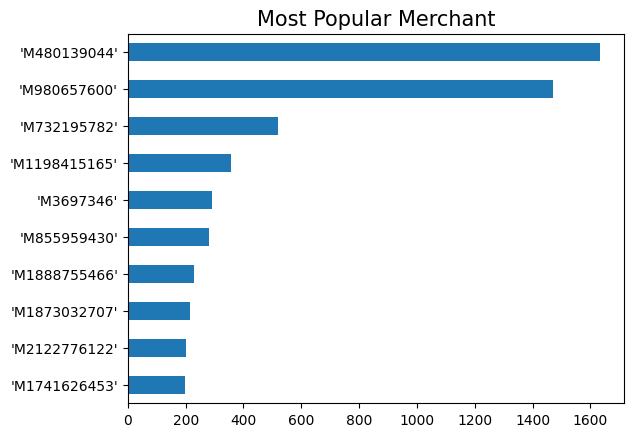

In [20]:
plt.title('Most Popular Merchant', fontsize=15)
df[df['fraud'] == 1].merchant.value_counts(ascending=True).tail(10).plot.barh();

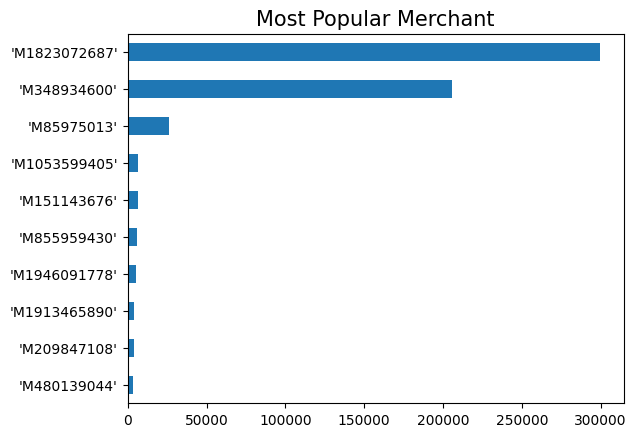

In [21]:
plt.title('Most Popular Merchant', fontsize=15)
df.merchant.value_counts(ascending=True).tail(10).plot.barh();

## 2- Bivariate Exploration:

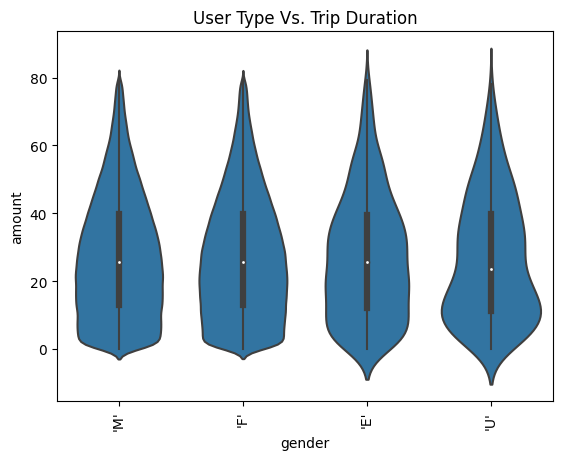

In [22]:
base_color = sns.color_palette()[0]
# to make the visiual more readable I have removed the outliers by taking the 95th precentile only
sns. violinplot (data = df.query ('amount < amount.quantile (0.95) '), x = 'gender', y = 'amount', color = base_color);
plt.title( 'User Type Vs. Trip Duration');
plt.xticks(rotation=90);

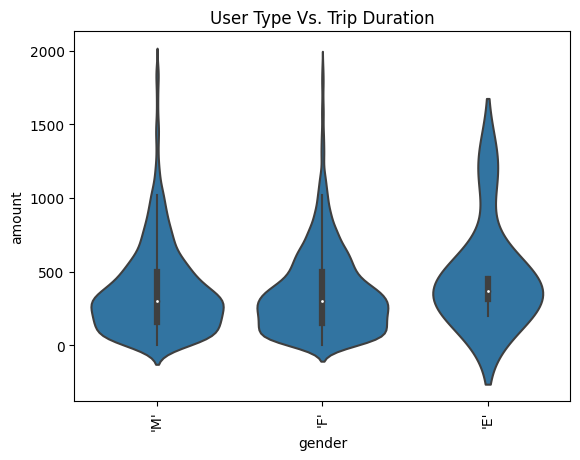

In [23]:
base_color = sns.color_palette()[0]
# to make the visiual more readable I have removed the outliers by taking the 95th precentile only
sns. violinplot (data = df[df['fraud'] == 1].query ('amount < amount.quantile (0.95) '), x = 'gender',
                 y = 'amount', color = base_color);
plt.title( 'User Type Vs. Trip Duration');
plt.xticks(rotation=90);

#### The above plot suggests that on average all genders tend to have the same spending amount with Unknown gender being slightly less. and ragrding the fraudulant transactions only we can see that 'E' has a lightly less average and no fraudulant transactions were made with a gender of 'U'.

In [24]:
def myCountPlot (df, xVar, huevar, order=None,  palette=None) :
    '''
(their defaults are set)
docstring: IMPORTANT explain function here
inputs:
output:
'''
# set plot dimensions
    plt.figure (figsize=[14, 6])
# plot
    sns.countplot (data=df, x = xVar, hue=huevar, edgecolor='black' , order=order,palette=palette) ;
# OPTIONAL: AFTER plotting, clean up variable names
    xVar = xVar.replace("_", " ") 
# replace _ with a space
    huevar=huevar.replace("_", " ")
# Add title and format it
    plt.title(f''' Distribution of {xVar} by {huevar}'''.title(), fontsize = 14, weight = "bold" )
# Add x label and format it
    plt.xlabel (xVar.title( ), fontsize = 10, weight = "bold")
# Add y label and format it
    plt.ylabel ('Frequency'.title(), fontsize = 10, weight = "bold" )
    plt.legend(loc = 1)

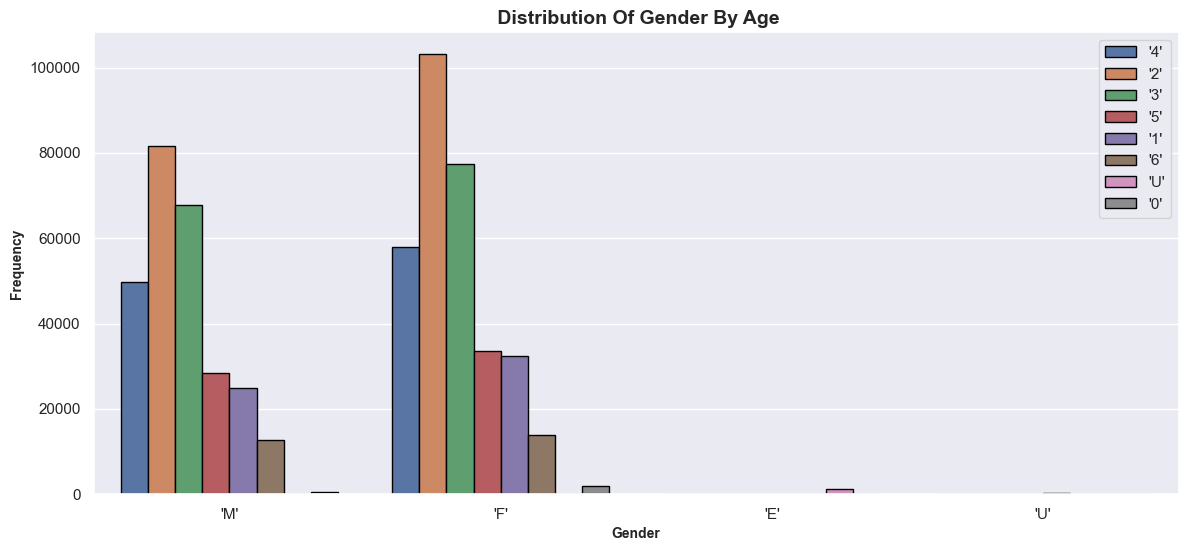

In [82]:
myCountPlot(df[df['fraud'] == 0], 'gender', 'age')

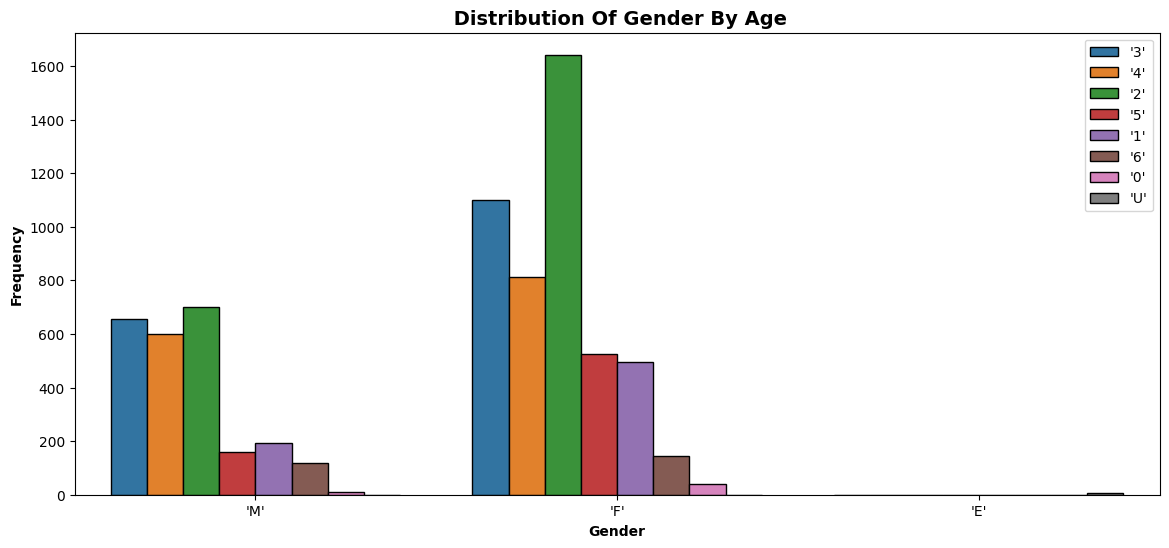

In [26]:
myCountPlot(df[df['fraud'] == 1], 'gender', 'age')

### the above barchart shows that Females from each age category has more transactions the Males in that same category.
### for the fraudulant transactions we can see that most of these transactions were done by females specially with the ages from 26-45.

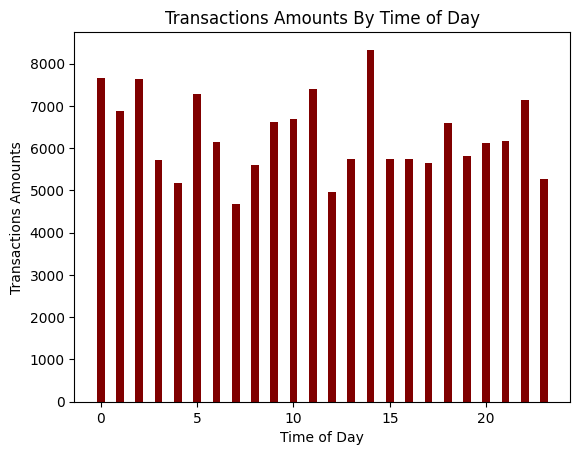

In [29]:
plt.bar(df['time_of_day'][df['fraud'] == 1], df['amount'][df['fraud'] == 1], color ='maroon',
        width = 0.4)
 
plt.xlabel("Time of Day")
plt.ylabel("Transactions Amounts")
plt.title("Transactions Amounts By Time of Day")
plt.show()

# Handling Imbalance

## Oversampling

In [30]:
class0 = df[df['fraud'] == 0]
class1 = df[df['fraud'] == 1]

In [31]:
class0.shape

(587443, 8)

In [32]:
unsampled_small = resample(class1, replace = True, n_samples = class0.shape[0], random_state = 42)
unsampled_small.head()

,customer,age,gender,merchant,category,amount,fraud,time_of_day
55957,'C1978250683','3','F','M732195782','es_travel',375.64,1,21
427654,'C2027892936','4','F','M480139044','es_health',242.96,1,14
412734,'C245117318','3','F','M855959430','es_hyper',89.07,1,10
409345,'C2113737065','2','F','M980657600','es_sportsandtoys',300.22,1,9
285236,'C1211514218','3','M','M732195782','es_travel',482.06,1,22


In [33]:
unsampled_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587443 entries, 55957 to 400868
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer     587443 non-null  object 
 1   age          587443 non-null  object 
 2   gender       587443 non-null  object 
 3   merchant     587443 non-null  object 
 4   category     587443 non-null  object 
 5   amount       587443 non-null  float64
 6   fraud        587443 non-null  int64  
 7   time_of_day  587443 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 38.1+ MB


In [34]:
df_os = pd.concat([unsampled_small, class0])
df_os.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1174886 entries, 55957 to 594642
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer     1174886 non-null  object 
 1   age          1174886 non-null  object 
 2   gender       1174886 non-null  object 
 3   merchant     1174886 non-null  object 
 4   category     1174886 non-null  object 
 5   amount       1174886 non-null  float64
 6   fraud        1174886 non-null  int64  
 7   time_of_day  1174886 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 76.2+ MB


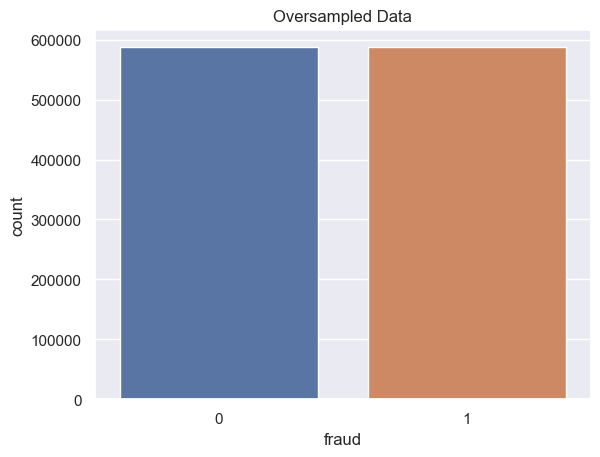

In [91]:
sns.set()
sns.countplot(data=df_os , x='fraud');
plt.title('Oversampled Data');

# Data Preprocessing and Feature Engineering

In [36]:
scaler = RobustScaler()

In [37]:
df_os.drop(['customer', 'merchant'], axis = 1, inplace = True)
df_os2 = pd.get_dummies(df_os)

In [38]:
x = df_os2.drop(['fraud'], axis = 1)
y = df_os2['fraud']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_scale = scaler.fit_transform(X_train)
x_test_scale = scaler.fit_transform(X_test)

# Model selection, Training, Evaluation, and Interpretation

## 1 XGBoost

In [40]:
xgb= XGBClassifier(n_estimators=10,max_depth=10,learning_rate=.05, random_state = 42)
evalset = [(x_train_scale, y_train), (x_test_scale,y_test)]
xgb.fit(x_train_scale , y_train, eval_set=evalset)

[0]	validation_0-logloss:0.64974	validation_1-logloss:0.64996
[1]	validation_0-logloss:0.61044	validation_1-logloss:0.61081
[2]	validation_0-logloss:0.57473	validation_1-logloss:0.57528
[3]	validation_0-logloss:0.54212	validation_1-logloss:0.54283
[4]	validation_0-logloss:0.51227	validation_1-logloss:0.51309
[5]	validation_0-logloss:0.48487	validation_1-logloss:0.48579
[6]	validation_0-logloss:0.45957	validation_1-logloss:0.46064
[7]	validation_0-logloss:0.43624	validation_1-logloss:0.43743
[8]	validation_0-logloss:0.41456	validation_1-logloss:0.41591
[9]	validation_0-logloss:0.39453	validation_1-logloss:0.39598


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [41]:
print (xgb.score(x_train_scale , y_train))
print (xgb.score(x_test_scale , y_test))

0.9636134821623987
0.9607479870398847


In [42]:
y_pred = xgb.predict(x_test_scale)
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)

Accuracy: 0.961


In [43]:
results = xgb.evals_result()

In [44]:
print(confusion_matrix(y_test, y_pred))

[[165239  11059]
 [  2776 173392]]


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    176298
           1       0.94      0.98      0.96    176168

    accuracy                           0.96    352466
   macro avg       0.96      0.96      0.96    352466
weighted avg       0.96      0.96      0.96    352466



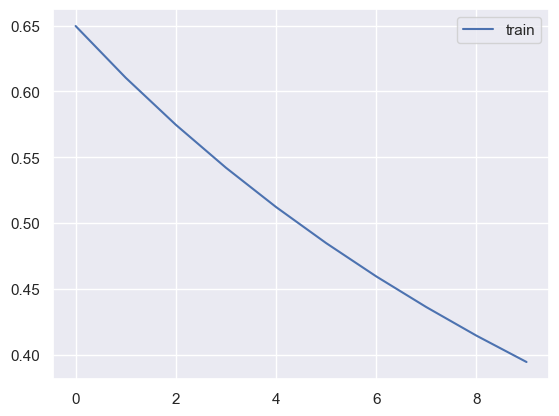

In [46]:
plt.plot(results['validation_0']['logloss'], label='train');
plt.legend()
plt.show()

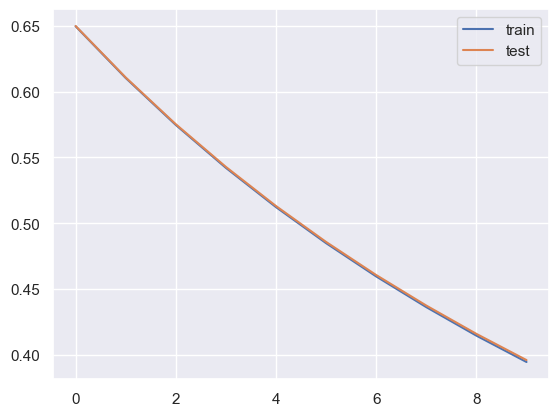

In [47]:
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

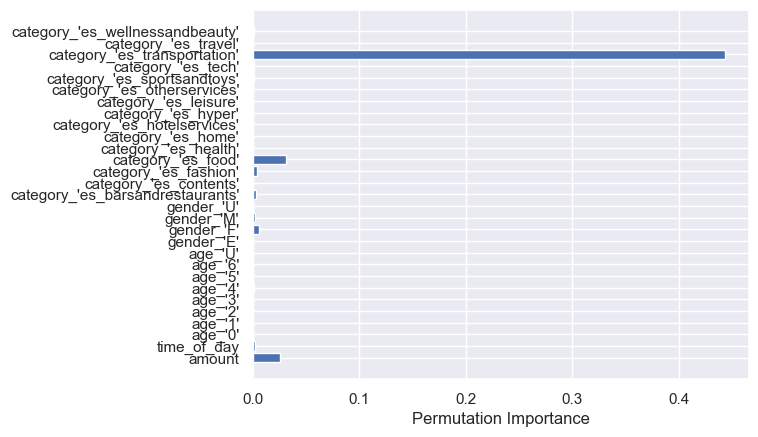

In [48]:
perm_importance = permutation_importance(xgb, x_test_scale, y_test)
plt.barh(x.columns.values, perm_importance.importances_mean);
plt.xlabel("Permutation Importance");

## ************************************

## 2 AdaBoost


### Fine-tuning and Optimization of adaboost using GridSearchCV

In [52]:
ada = AdaBoostClassifier(random_state = 42)

In [53]:
grid_param = {'n_estimators': [5, 10, 15],
             'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
             'algorithm': ['SAMME.R', 'SAMME']}

In [54]:
ada_GS = GridSearchCV(ada, grid_param, n_jobs = -1)
ada_GS.fit(x_train_scale , y_train)

GridSearchCV(estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME.R', 'SAMME'],
                         'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175,
                                           0.2],
                         'n_estimators': [5, 10, 15]})

In [55]:
ada_GS.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}

In [56]:
print (ada_GS.score(x_train_scale , y_train));
print (ada_GS.score(x_test_scale , y_test));

0.9523357894992827
0.9521372274205172


In [57]:
y_pred_ada = ada_GS.predict(x_test_scale)
print(confusion_matrix(y_test, y_pred_ada))

[[159428  16870]
 [     0 176168]]


In [58]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    176298
           1       0.91      1.00      0.95    176168

    accuracy                           0.95    352466
   macro avg       0.96      0.95      0.95    352466
weighted avg       0.96      0.95      0.95    352466



### Using the best parameters found for adaboost

In [64]:
ada = AdaBoostClassifier(algorithm ='SAMME.R', learning_rate= 0.1, n_estimators= 10, random_state = 42)
ada.fit(x_train_scale , y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=10, random_state=42)

In [65]:
print (ada.score(x_train_scale , y_train));
print (ada.score(x_test_scale , y_test));

0.9523357894992827
0.9521372274205172


In [66]:
y_pred_ada = ada.predict(x_test_scale)
print(confusion_matrix(y_test, y_pred_ada))

[[159428  16870]
 [     0 176168]]


In [67]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    176298
           1       0.91      1.00      0.95    176168

    accuracy                           0.95    352466
   macro avg       0.96      0.95      0.95    352466
weighted avg       0.96      0.95      0.95    352466



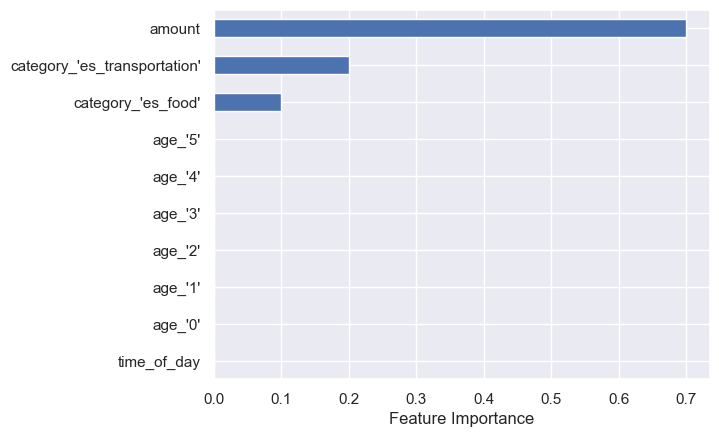

In [68]:
feat_importances = pd.Series(ada.feature_importances_, index=x.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh');
plt.xlabel("Feature Importance");

## *******************************

## 3 RandomForest

In [69]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_split = 3,
                            min_samples_leaf = 1, random_state = 42)
rf.fit(x_train_scale, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=50,
                       random_state=42)

In [70]:
print (rf.score(x_train_scale , y_train));
print (rf.score(x_test_scale , y_test));

0.9638834172320712
0.963051755346615


In [71]:
y_pred_rf = rf.predict(x_test_scale)
print(confusion_matrix(y_test, y_pred_rf))

[[164363  11935]
 [  1088 175080]]


In [72]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    176298
           1       0.94      0.99      0.96    176168

    accuracy                           0.96    352466
   macro avg       0.96      0.96      0.96    352466
weighted avg       0.96      0.96      0.96    352466



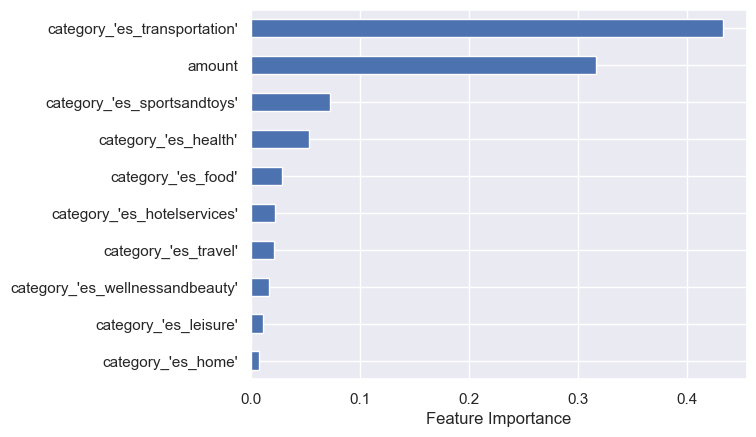

In [73]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh');
plt.xlabel("Feature Importance");

## ******************************

## 4 Logistic Regression

In [74]:
log = LogisticRegression()
log.fit(x_train_scale, y_train)

LogisticRegression()

In [75]:
print (log.score(x_train_scale , y_train));
print (log.score(x_test_scale , y_test));

0.9581685756669341
0.9581463176590083


In [76]:
y_pred_log = log.predict(x_test_scale)
print(confusion_matrix(y_test, y_pred_log))

[[163959  12339]
 [  2413 173755]]


In [77]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    176298
           1       0.93      0.99      0.96    176168

    accuracy                           0.96    352466
   macro avg       0.96      0.96      0.96    352466
weighted avg       0.96      0.96      0.96    352466



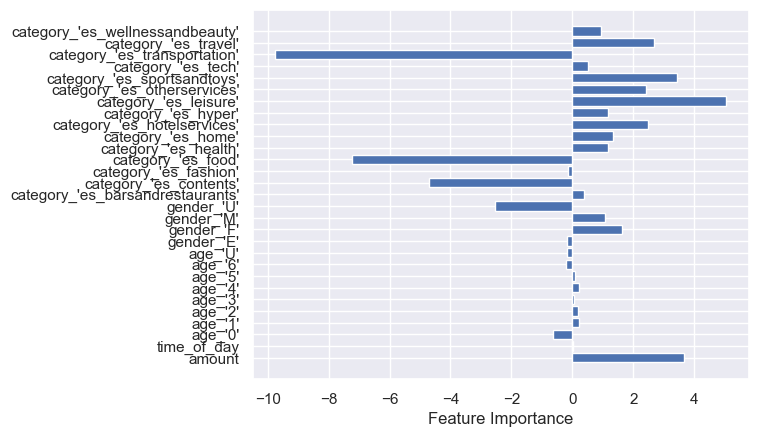

In [79]:
plt.barh(x.columns.values, log.coef_[0]);
plt.xlabel("Feature Importance");

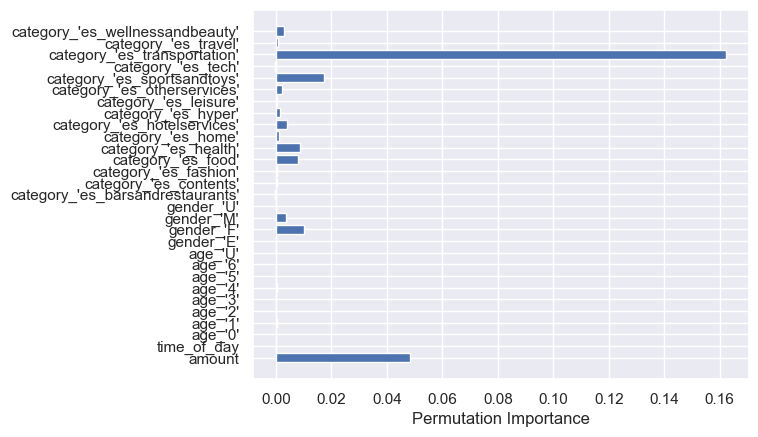

In [80]:
perm_importance = permutation_importance(log, x_test_scale, y_test)
plt.barh(x.columns.values, perm_importance.importances_mean);
plt.xlabel("Permutation Importance");

## *******************************

## 1.2.5 Voting Classifier

In [83]:
clf1 = XGBClassifier(n_estimators=10,max_depth=10,learning_rate=.05, random_state = 42)
clf2 = AdaBoostClassifier(algorithm ='SAMME.R', learning_rate= 0.1, n_estimators= 10, random_state = 42)
clf3 = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_split = 3,
                              min_samples_leaf = 1, random_state = 42)
clf4 = LogisticRegression()

In [84]:
v_clf=VotingClassifier(estimators=[("xgb",clf1),("Ada",clf2),('rf',clf3), ('log', clf4)],voting='hard')

In [85]:
v_clf.fit(x_train_scale, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=10, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('Ada',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=10,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=3,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('log', LogisticRegression())])

In [86]:
print (v_clf.score(x_train_scale , y_train));
print (v_clf.score(x_test_scale , y_test));

0.9623610807130176
0.9617268048549363


In [87]:
y_pred_v_clf = v_clf.predict(x_test_scale)

In [88]:
print(confusion_matrix(y_test, y_pred_v_clf))

[[164405  11893]
 [  1597 174571]]


In [89]:
print(classification_report(y_test, y_pred_v_clf))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    176298
           1       0.94      0.99      0.96    176168

    accuracy                           0.96    352466
   macro avg       0.96      0.96      0.96    352466
weighted avg       0.96      0.96      0.96    352466



### from the classification report above we can see that the we have a very good f1 score to measure our model's performance.

In [92]:
# save the model
import pickle

# save
with open('VotingClassifier.pkl','wb') as f:
    pickle.dump(v_clf,f)